In [1]:

%load_ext autoreload
%autoreload 2
import os
import dask
import panel
import pandas as pd
import matplotlib.pyplot as plt
import nisardev as nisar
import grimpfunc as grimp
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import geopandas as gpd
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)  # Avoid problems with too many open connections at NSIDC
panel.extension() 
import xarray as xr
import numpy as np
import geopandas as gpd

In [2]:
velocity = xr.open_dataset('/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/data/MEaSUREs_0766/JakobshavnIsbraeVelocitySeries.nc')
centreline = gpd.read_file('/Users/sofiasuhinin/Desktop/GrIS_Calving/flowlines/glacier0001_iter03.shp')
terminus = pd.read_csv('/Users/sofiasuhinin/Desktop/GrIS_Calving/Jakobshavn-Isbrae-CalvingStatistics/centreline1.csv', skiprows = 1)

In [3]:
terminus

,Year,Month,Day,Serial Date (num days from 0th Jan 0000),Terminus Position on flowline,Terminus position relative to most recent observation (m),Terminus change (m),Rate of Terminus Change (m/yr),Terminus Width (m),Terminus path length (m),Mean distance between nodes (m)
0,2015,1,3,735970.0,1492.80,445.630,NaN,0.0,12146,22522,369.22
1,2015,1,15,735980.0,1036.50,-10.635,-456.270,-13878.0,11859,20521,336.42
2,2015,1,27,735990.0,1112.70,65.546,76.181,2317.2,11570,22995,242.05
3,2015,2,8,736000.0,790.49,-256.690,-322.240,-9801.4,12657,25215,345.42
4,2015,2,20,736020.0,1937.40,890.210,1146.900,34885.0,11831,21361,220.21
...,...,...,...,...,...,...,...,...,...,...,...
241,2021,11,27,738490.0,1394.10,346.900,-264.480,-16089.0,10801,29389,212.97
242,2021,12,3,738490.0,1204.90,157.720,-189.170,-11508.0,11095,31781,254.25
243,2021,12,9,738500.0,1446.70,399.550,241.830,14711.0,11327,32199,263.92
244,2021,12,15,738500.0,1280.10,232.880,-166.670,-10139.0,11422,30307,240.53


In [4]:
#change to date time (this is a thing)
terminus["Date"] = pd.to_datetime(
    dict(year = terminus["Year"],
        month = terminus["Month"],
        day = terminus["Day"])
)

terminus = terminus.rename(columns = {
    "Terminus Position on flowline": "L",
    "Terminus change (m)": "del_L"
})

#for simplicity i just want these (for now, tbd)
terminus_columns = ["Date", "L", "del_L"]
terminus = terminus[terminus_columns].sort_values("Date").reset_index(drop= True)


In [5]:
terminus

,Date,L,del_L
0,2015-01-03,1492.80,NaN
1,2015-01-15,1036.50,-456.270
2,2015-01-27,1112.70,76.181
3,2015-02-08,790.49,-322.240
4,2015-02-20,1937.40,1146.900
...,...,...,...
241,2021-11-27,1394.10,-264.480
242,2021-12-03,1204.90,-189.170
243,2021-12-09,1446.70,241.830
244,2021-12-15,1280.10,-166.670


In [6]:
#terminus df 
df = terminus.copy().sort_values("Date").reset_index(drop=True)

#dt calc
df["dt_days"] = df["Date"].diff().dt.days
df["dt_years"] = df["dt_days"] / 365.25

#dL calc
df["dL"] = df["L"].diff()
df["dLdt_per_year"] = df["dL"] / df["dt_years"]

df[["Date", "L", "dt_days", "dL", "dLdt_per_year"]].head(10)

#dLdt = dL ( 6 days) - terminus change between data / dt (per year)




,Date,L,dt_days,dL,dLdt_per_year
0,2015-01-03,1492.80,NaN,NaN,NaN
1,2015-01-15,1036.50,12.0,-456.30,-13888.631250
2,2015-01-27,1112.70,12.0,76.20,2319.337500
3,2015-02-08,790.49,12.0,-322.21,-9807.266875
4,2015-02-20,1937.40,12.0,1146.91,34909.073125
5,2015-03-04,1518.00,12.0,-419.40,-12765.487500
6,2015-03-16,1139.70,12.0,-378.30,-11514.506250
7,2015-03-28,645.19,12.0,-494.51,-15051.648125
8,2015-04-09,884.89,12.0,239.70,7295.868750
9,2015-04-21,489.40,12.0,-395.49,-12037.726875


In [7]:
#so w my velocity i should pick a point on the terminus right 
# - probably where it intersects the centreline
# just pulling random points to visualise - can check for actual coordiantes on QGIS

centreline.length

0    564300.353452
dtype: float64

In [8]:
velocity

<xarray.Dataset> Size: 1GB
Dimensions:      (x: 501, y: 501, time: 463, band: 3)
Coordinates:
  * x            (x) float64 4kB -2.5e+05 -2.498e+05 ... -1.502e+05 -1.5e+05
  * y            (y) float64 4kB -2.15e+06 -2.15e+06 ... -2.25e+06 -2.25e+06
  * time         (time) datetime64[ns] 4kB 2015-01-06T12:00:00 ... 2024-12-14...
  * band         (band) <U2 24B 'vx' 'vy' 'vv'
    name         <U4 16B ...
    _FillValue   (band) float64 24B ...
    time1        (time) datetime64[ns] 4kB ...
    time2        (time) datetime64[ns] 4kB ...
Data variables:
    spatial_ref  int64 8B ...
    VelocityMap  (time, band, y, x) float32 1GB ...

In [9]:
vv = velocity["VelocityMap"].sel(band="vv")
print("min, max:", float(vv.min()), float(vv.max()))

min, max: 0.001237369142472744 7073.78564453125


In [10]:
print(velocity)

<xarray.Dataset> Size: 1GB
Dimensions:      (x: 501, y: 501, time: 463, band: 3)
Coordinates:
  * x            (x) float64 4kB -2.5e+05 -2.498e+05 ... -1.502e+05 -1.5e+05
  * y            (y) float64 4kB -2.15e+06 -2.15e+06 ... -2.25e+06 -2.25e+06
  * time         (time) datetime64[ns] 4kB 2015-01-06T12:00:00 ... 2024-12-14...
  * band         (band) <U2 24B 'vx' 'vy' 'vv'
    name         <U4 16B ...
    _FillValue   (band) float64 24B ...
    time1        (time) datetime64[ns] 4kB ...
    time2        (time) datetime64[ns] 4kB ...
Data variables:
    spatial_ref  int64 8B ...
    VelocityMap  (time, band, y, x) float32 1GB ...


In [11]:
vv = velocity["VelocityMap"].sel(band="vv")
xmin, xmax = float(vv.x.min()), float(vv.x.max())
ymin, ymax = float(vv.y.min()), float(vv.y.max())
print(xmin, xmax, ymin, ymax)

-250000.0 -150000.0 -2250000.0 -2150000.0


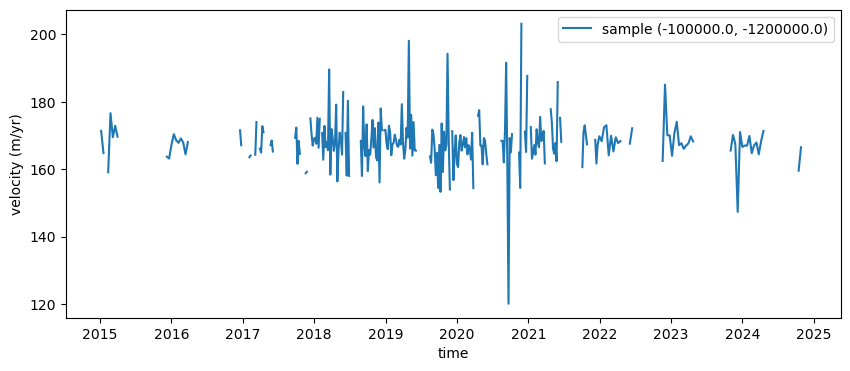

In [12]:
x0 = -100000.0
y0 = -1200000.0

label = 'sample'

vv_band = velocity["VelocityMap"].sel(band='vv')

vel_sample_pt = vv_band.sel(x=x0, y=y0, method='nearest')
df_selected_point = vel_sample_pt.to_dataframe().reset_index()

plt.figure(figsize=(10,4))
plt.plot(df_selected_point['time'], df_selected_point['VelocityMap'], label=f'{label} ({x0}, {y0})')
plt.xlabel('time')
plt.ylabel('velocity (m/yr)')
plt.legend()
plt.show()

#should clean this? claire has a notebook on this 
#should also find a way to pick a point near the terminsu 

In [13]:
vv = velocity["VelocityMap"].sel(band="vv") 

vel_series = vv.sel(x=x0, y=y0, method="nearest").to_series()

df_vel = vel_series.reset_index().rename(columns={
    "time": "date",
    "VelocityMap": "u"
})

df_vel = df_vel.sort_values("date").reset_index(drop=True)

print(df_vel)

                   date           u
0   2015-01-06 12:00:00  171.360504
1   2015-01-18 12:00:00  164.782471
2   2015-01-30 12:00:00         NaN
3   2015-02-11 12:00:00  159.095322
4   2015-02-23 12:00:00  176.612976
..                  ...         ...
458 2024-10-27 12:00:00  166.492813
459 2024-11-08 12:00:00         NaN
460 2024-11-20 12:00:00  168.804337
461 2024-12-02 12:00:00         NaN
462 2024-12-14 12:00:00         NaN

[463 rows x 2 columns]


In [15]:
df

,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125
...,...,...,...,...,...,...,...
241,2021-11-27,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500
242,2021-12-03,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000
243,2021-12-09,1446.70,241.830,6.0,0.016427,241.80,14719.575000
244,2021-12-15,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000


In [17]:
# assuming a veloicty of 1500 m/a to begin the calving series

u_constant = 1500.0 #unit is m /year 

df["u_per_year"] = u_constant

df


,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year,u_per_year
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN,1500.0
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,1500.0
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500,1500.0
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,1500.0
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,1500.0
...,...,...,...,...,...,...,...,...
241,2021-11-27,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,1500.0
242,2021-12-03,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,1500.0
243,2021-12-09,1446.70,241.830,6.0,0.016427,241.80,14719.575000,1500.0
244,2021-12-15,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,1500.0


In [ ]:
df["calving"] = df["u_per_year"] - df["dLdt_per_year"]

#calving unit is m /yr
# calving rate > 0 : terminus advance  (due to velocity)
# calving rate < 0 : terminus retreat (due to calving)

In [19]:
df

,Date,L,del_L,dt_days,dt_years,dL,dLdt_per_year,u_per_year,calving
0,2015-01-03,1492.80,NaN,NaN,NaN,NaN,NaN,1500.0,NaN
1,2015-01-15,1036.50,-456.270,12.0,0.032854,-456.30,-13888.631250,1500.0,15388.631250
2,2015-01-27,1112.70,76.181,12.0,0.032854,76.20,2319.337500,1500.0,-819.337500
3,2015-02-08,790.49,-322.240,12.0,0.032854,-322.21,-9807.266875,1500.0,11307.266875
4,2015-02-20,1937.40,1146.900,12.0,0.032854,1146.91,34909.073125,1500.0,-33409.073125
...,...,...,...,...,...,...,...,...,...
241,2021-11-27,1394.10,-264.480,6.0,0.016427,-264.50,-16101.437500,1500.0,17601.437500
242,2021-12-03,1204.90,-189.170,6.0,0.016427,-189.20,-11517.550000,1500.0,13017.550000
243,2021-12-09,1446.70,241.830,6.0,0.016427,241.80,14719.575000,1500.0,-13219.575000
244,2021-12-15,1280.10,-166.670,6.0,0.016427,-166.60,-10141.775000,1500.0,11641.775000


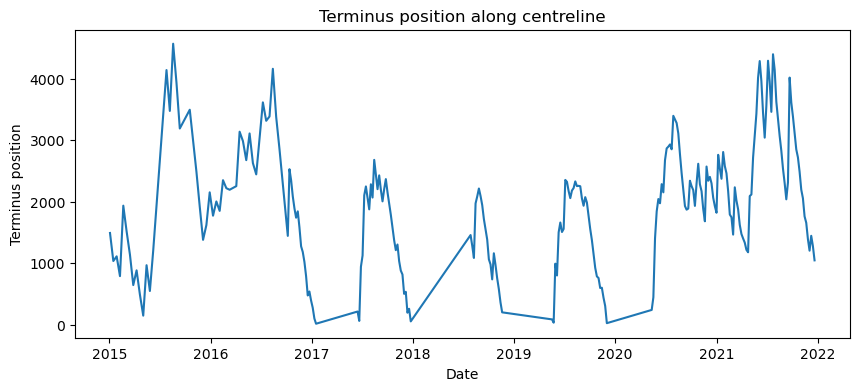

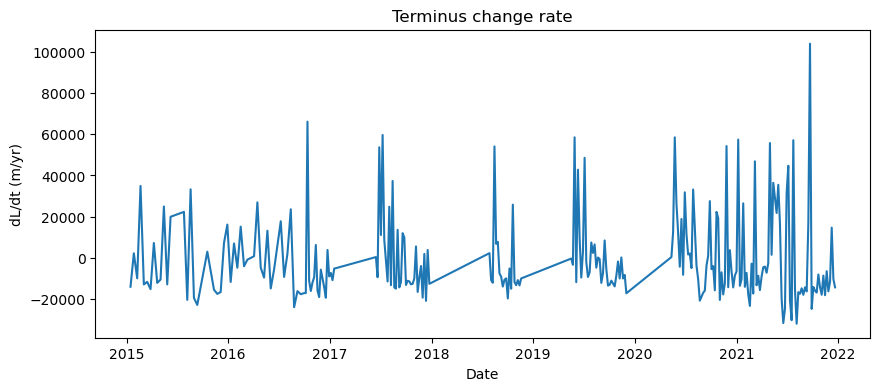

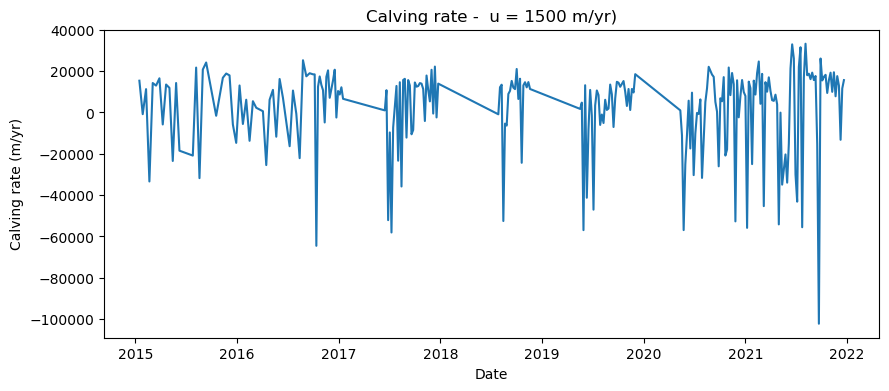

In [21]:

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["L"])
plt.xlabel("Date")
plt.ylabel("Terminus position")
plt.title("Terminus position along centreline")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["dLdt_per_year"])
plt.xlabel("Date")
plt.ylabel("dL/dt (m/yr)")
plt.title("Terminus change rate")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df["Date"], df["calving"])
plt.xlabel("Date")
plt.ylabel("Calving rate (m/yr)")
plt.title("Calving rate -  u = 1500 m/yr)")
plt.show()